# Spectrum Sensing Delayed Feedback Reservoir (DFR)

## Import Packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Define Mackey-Glass Transfer Function

[Mackey-Glass equation on Scholarpedia](http://www.scholarpedia.org/article/Mackey-Glass_equation)

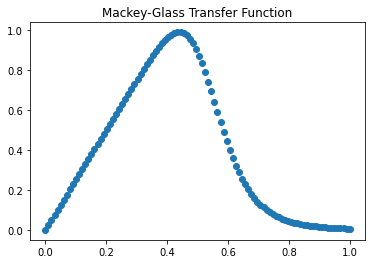

In [6]:
# mackey-glass function definition
def mg(x):
    a = 2
    b = 0.8
    c = 0.2
    d = 2.1
    p = 10

    return (a * x) / (b + c * np.power( (d * x), p) )

# graph mackey-glass function characteristics
x = np.linspace(0,1,100)
plt.title("Mackey-Glass Transfer Function")
plt.scatter(x,mg(x))
plt.show()